### Chapter 11: Partial differential equations (PDEs)
* multivariate equations with derivatives of >1 dependent variables (ie, derivatives in equation are partial derivatives)
 Two common techniques: 1) finite-difference methods (FDMs: derivatives are approximated), and 2) finite-element methods (FEMs - unknown funct written as linear combination of simple basis functions)
* PDE solvers == **much** more computationally demanding due to #points expanding exponentially with #dimensions. Heavy reliance on sparse matrix operations

In [5]:
import numpy as np

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d

In [7]:
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.linalg as la

In [8]:
# FEniCS FEM framework
import dolfin
import mshr

ImportError: No module named 'dolfin'

### Finite-difference method - 1D example

* Steady-state heat equation in 1D:

$$-5 = u_{xx}, u(x=0) = 1, u(x=1) = 2$$

$$
u_{xx}[n] = (u[n-1] - 2u[n] + u[n+1])/dx^2
$$

In [9]:
N     = 5          # interior points
u0,u1 = 1,2        # function values at boundaries
dx    = 1.0/(N+1)  # spacing between neighboring points

In [10]:
# equation for interior points = Au=b
A = (np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)) / dx**2
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

In [12]:
d       = -5*np.ones(N)
d[0]   -= u0/dx**2
d[N-1] -= u1/dx**2
d

array([-41.,  -5.,  -5.,  -5., -77.])

In [13]:
# apply SciPy linear equation solver (can also use np.linalg.solve)
u = np.linalg.solve(A, d)
u

array([ 1.51388889,  1.88888889,  2.125     ,  2.22222222,  2.18055556])

In [14]:
# for visualization. x = coordinate points; U = boundray vals + interior pts
x = np.linspace(0, 1, N+2)
U = np.hstack([[u0], u, [u1]])

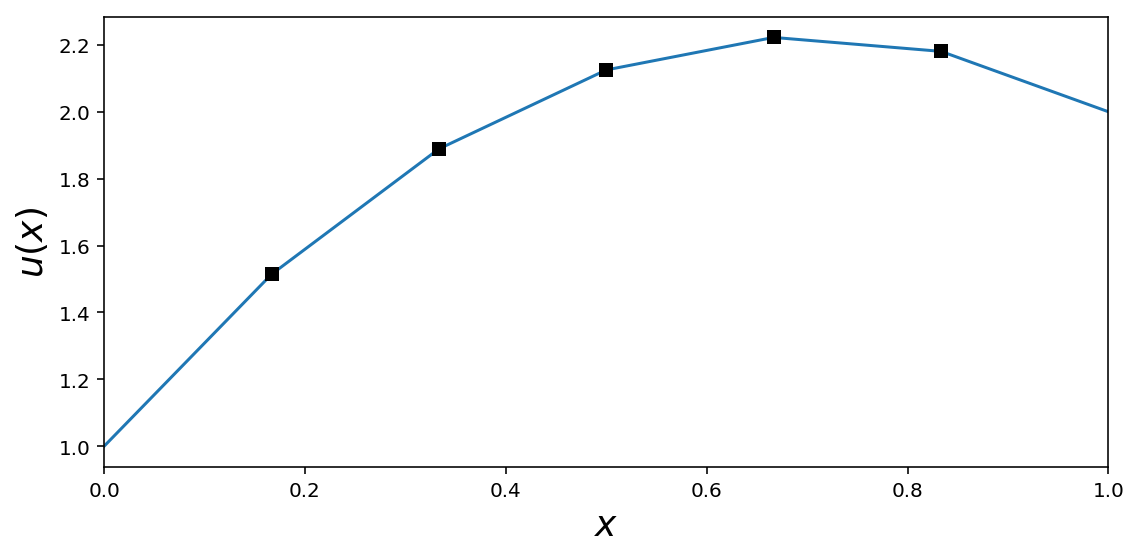

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, U)
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)
fig.savefig("ch11-fdm-1d.pdf")
fig.tight_layout();

## 2d example

laplace equation: $u_{xx} + u_{yy} = 0$

on boundary:

$$
u(x=0) = u(x=1) = u(y = 0) = u(y = 1) = 10
$$

$$
u_{xx}[m, n] = (u[m-1, n] - 2u[m,n] + u[m+1,n])/dx^2
$$

$$
u_{yy}[m, n] = (u[m, n-1] - 2u[m,n] + u[m,n+1])/dy^2
$$

final equation

$$
0 
= 
(u[m-1 + N n] - 2u[m + N n] + u[m+1 + N n])/dx^2
+
(u[m + N *(n-1)] - 2u[m + N* n] + u[m + N(n+1]))/dy^2
= 
(u[m + N n -1] - 2u[m + N n] + u[m + N n + 1])/dx^2
+
(u[m + N n -N)] - 2u[m + N n] + u[m + N n + N]))/dy^2
$$

In [16]:
N = 100               # number of interior points
u0_t, u0_b = 5, -5    # boundary values of unit square
u0_l, u0_r = 3, -1
dx = 1. / (N+1)

In [17]:
A_1d = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 * sp.eye(N))/dx**2

In [19]:
A = sp.kron(sp.eye(N), A_1d) + (sp.eye(N**2, k=-N) + sp.eye(N**2, k=N))/dx**2
A

# 10Kx10K elements with 49.6K nonzero (very sparse)

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

In [20]:
A.nnz * 1.0/ np.prod(A.shape) * 2000

0.99199999999999999

In [21]:
d = np.zeros((N, N))

d[0,  :] += -u0_b 
d[-1, :] += -u0_t
d[:,  0] += -u0_l
d[:, -1] += -u0_r

d = d.reshape(N**2) / dx**2
d.shape

(10000,)

In [22]:
# solve, then reshape:
u = sp.linalg.spsolve(A, d).reshape(N, N)

In [23]:
# for plotting:
# combine u with boundary conditions

U = np.vstack(
    [np.ones((1, N+2)) * u0_b,
     np.hstack([np.ones((N, 1)) * u0_l, 
                u, 
                np.ones((N, 1)) * u0_r]),
     np.ones((1, N+2)) * u0_t])

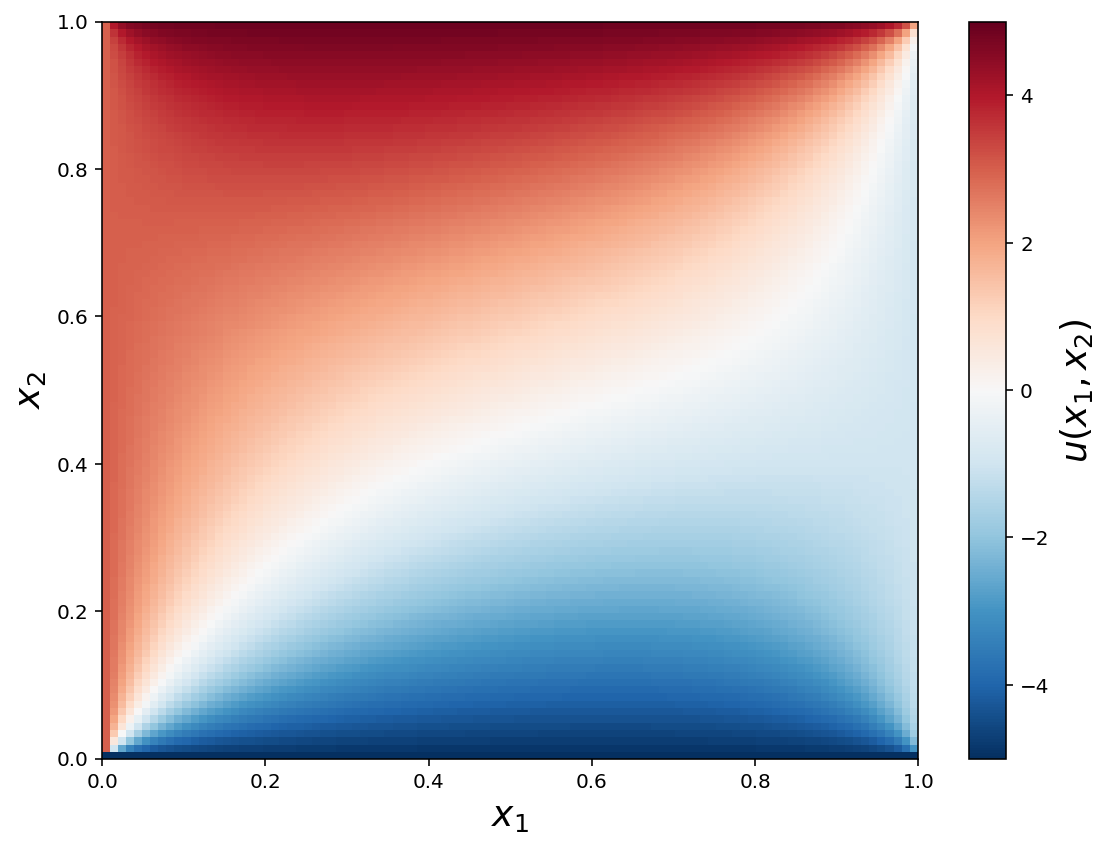

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
fig.savefig("ch11-fdm-2d.pdf")
fig.tight_layout()

# plots solution to 2D heat equation with Dirichlet boundary conditions

In [26]:
x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

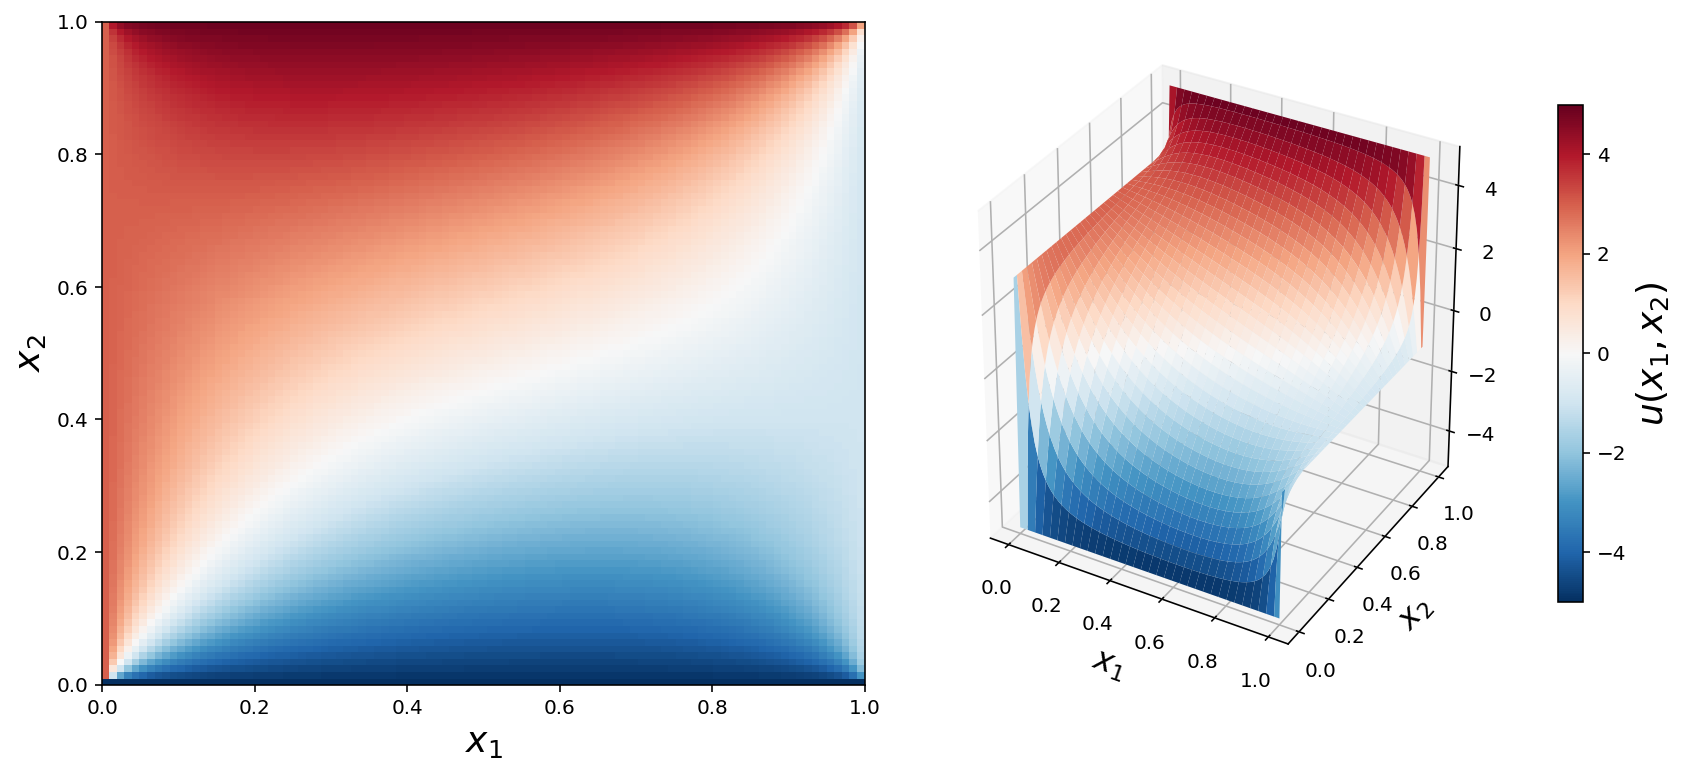

In [27]:
fig = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('RdBu_r')

ax = fig.add_subplot(1, 2, 1)
p = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)
cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

fig.savefig("ch11-fdm-2d.pdf")
fig.savefig("ch11-fdm-2d.png")
fig.tight_layout()

### Compare performance when using dense/sparse matrices

In [28]:
A_dense = A.todense()

In [29]:
%timeit np.linalg.solve(A_dense, d)

1 loop, best of 3: 4.66 s per loop


In [30]:
%timeit la.solve(A_dense, d)

1 loop, best of 3: 4.9 s per loop


In [31]:
%timeit sp.linalg.spsolve(A, d)

10 loops, best of 3: 34.1 ms per loop


In [33]:
# ratio
4.9 / 34.1e-3

143.69501466275662

### 2d example with source term

In [34]:
d = - np.ones((N, N))
d = d.reshape(N**2)

In [35]:
u = sp.linalg.spsolve(A, d).reshape(N, N)

In [36]:
U = np.vstack([np.zeros((1, N+2)),
               np.hstack([np.zeros((N, 1)), u, np.zeros((N, 1))]),
               np.zeros((1, N+2))])

In [37]:
x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

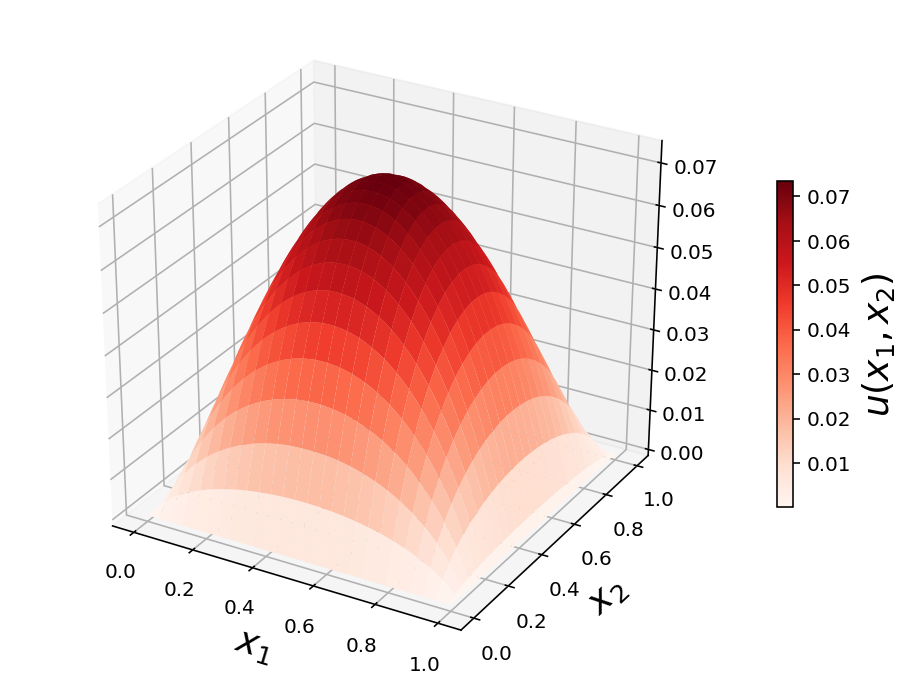

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, U, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

## FEniCS

In [41]:
import dolfin

In [42]:
import mshr

In [43]:
dolfin.parameters["reorder_dofs_serial"] = False
dolfin.parameters["allow_extrapolation"] = True

In [44]:
N1 = N2 = 75

In [45]:
mesh = dolfin.RectangleMesh(0, 0, 1, 1, N1, N2)

In [46]:
dolfin.RectangleMesh(0, 0, 1, 1, 10, 10)

### Function space from mesh

In [47]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

DEBUG:FFC:Reusing form from cache.


### Variational problem

In [48]:
u = dolfin.TrialFunction(V)

In [49]:
v = dolfin.TestFunction(V)

In [50]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [51]:
f1 = dolfin.Constant(1.0)

In [52]:
L1 = f1 * v * dolfin.dx

In [53]:
f2 = dolfin.Expression("x[0]*x[0] + x[1]*x[1]")

In [54]:
L2 = f2 * v * dolfin.dx

### Boundary conditions

In [55]:
u0 = dolfin.Constant(0)

In [56]:
def u0_boundary(x, on_boundary):
    # try to pin down the function at some interior region:
    #if np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2) < 0.1:
    #    return True
    return on_boundary

In [57]:
bc = dolfin.DirichletBC(V, u0, u0_boundary)

### Solve the problem

In [58]:
A = dolfin.assemble(a)

DEBUG:FFC:Reusing form from cache.


In [59]:
b = dolfin.assemble(L1)

DEBUG:FFC:Reusing form from cache.


In [60]:
bc.apply(A, b)

In [61]:
u_sol1 = dolfin.Function(V)

In [62]:
dolfin.solve(A, u_sol1.vector(), b)

1

In [63]:
u_sol2 = dolfin.Function(V)

In [64]:
dolfin.solve(a == L2, u_sol2, bc)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


### Dolfin plot

In [65]:
dolfin.plot(u_sol1)
dolfin.interactive()

### Save VTK files

In [66]:
dolfin.File('u_sol1.pvd') << u_sol1

In [67]:
dolfin.File('u_sol2.pvd') << u_sol2

In [68]:
f = dolfin.File('combined.pvd')
f << mesh
f << u_sol1
f << u_sol2

### Function evaluation

In [69]:
u_sol1([0.21, 0.67])

0.0466076997781351

### Obtain NumPy arrays

In [70]:
u_mat1 = u_sol1.vector().array().reshape(N1+1, N2+1)

In [71]:
u_mat2 = u_sol2.vector().array().reshape(N1+1, N2+1)

In [72]:
X, Y = np.meshgrid(np.linspace(0, 1, N1+2), np.linspace(0, 1, N2+2))

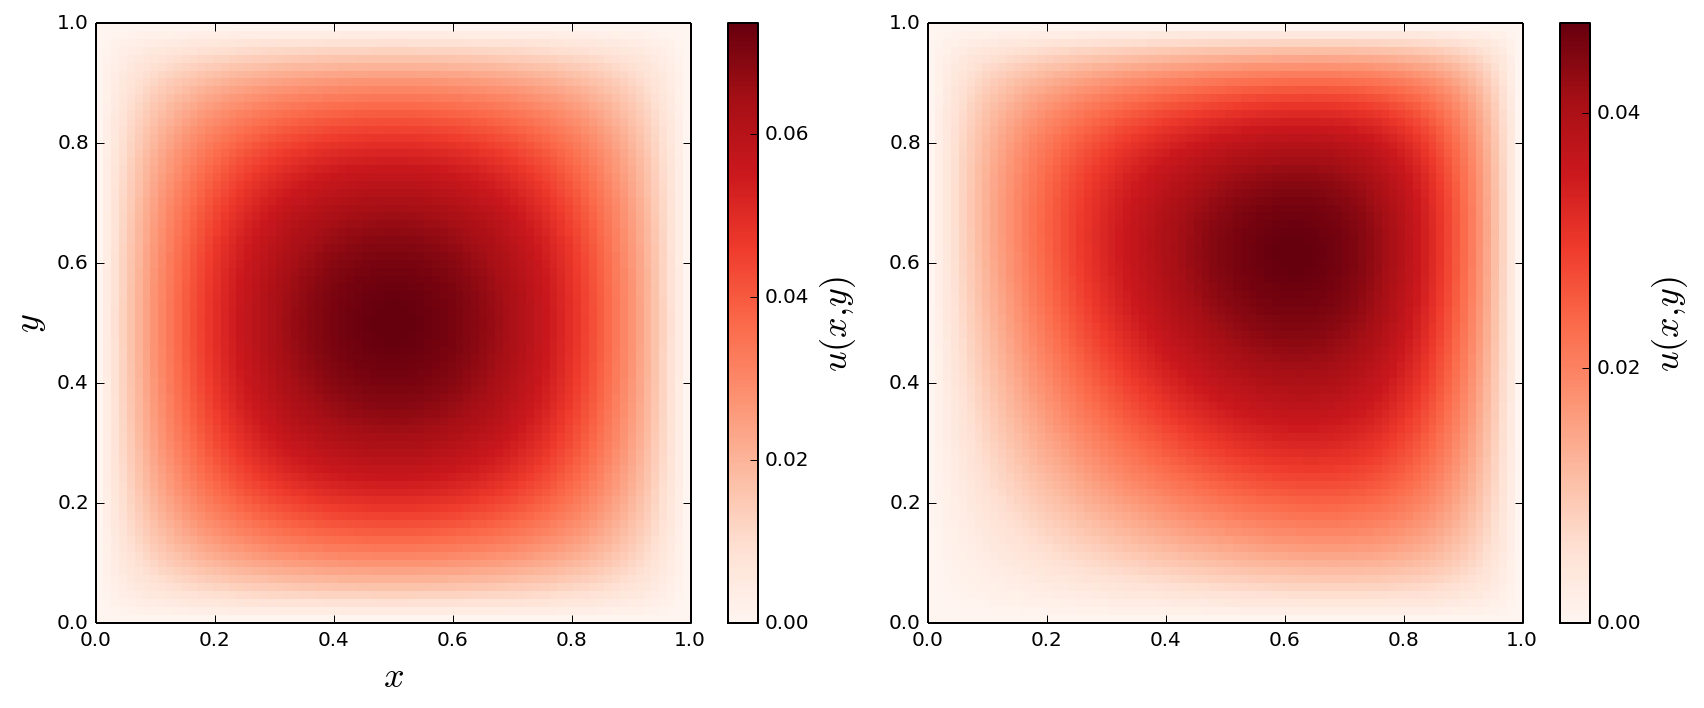

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
cmap = mpl.cm.get_cmap('Reds')

c = ax1.pcolor(X, Y, u_mat1, cmap=cmap)
cb = plt.colorbar(c, ax=ax1)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04, 0.06])

c = ax2.pcolor(X, Y, u_mat2, cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

fig.savefig("ch11-fdm-2d-ex1.pdf")
fig.savefig("ch11-fdm-2d-ex1.png")
fig.tight_layout()

In [74]:
X, Y = np.meshgrid(np.linspace(0, 1, N1+1), np.linspace(0, 1, N2+1))

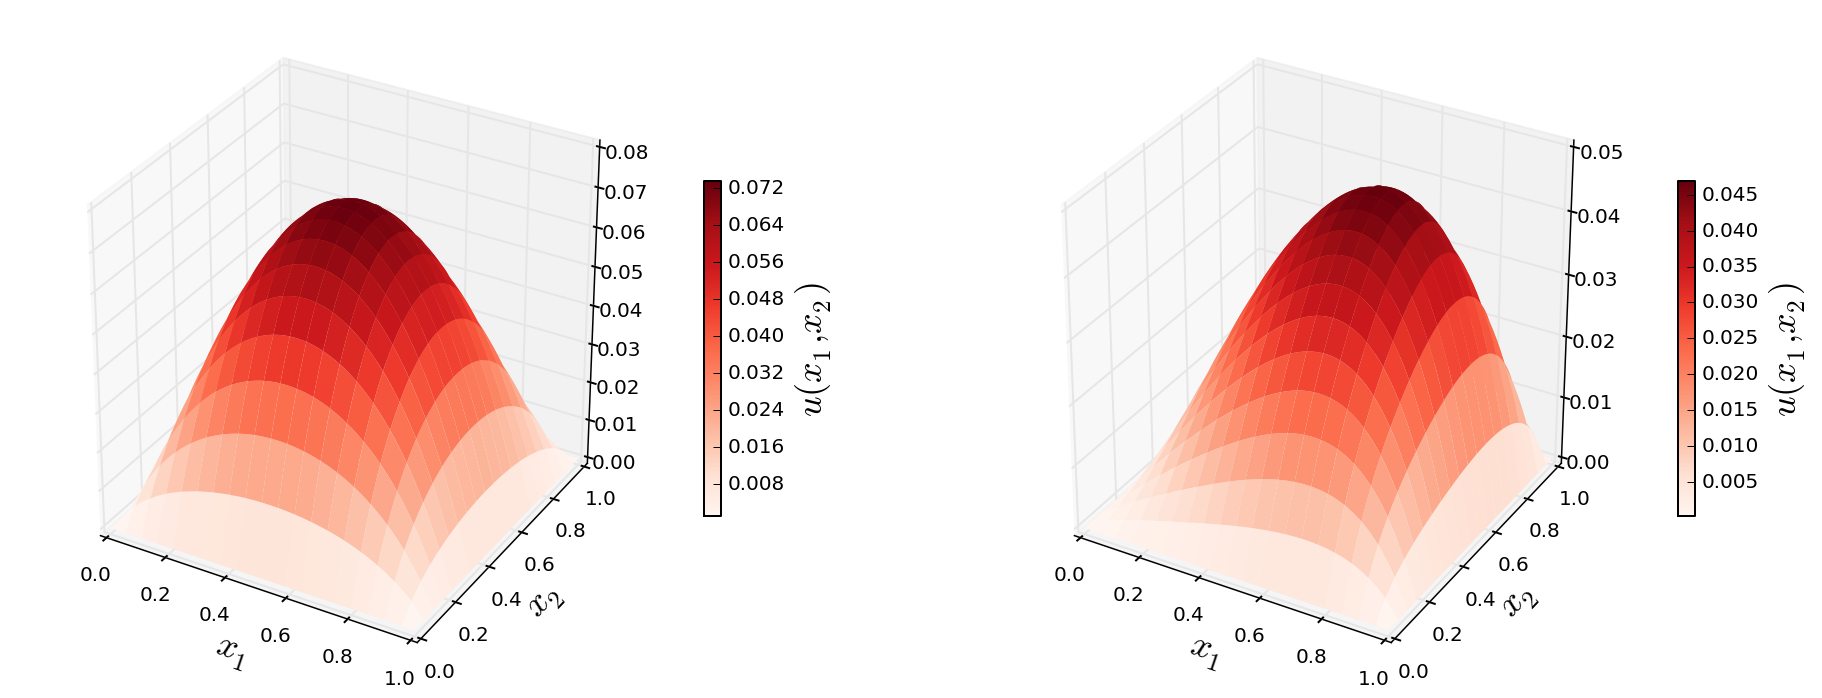

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

p = ax1.plot_surface(X, Y, u_mat1, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, ax=ax1, shrink=0.5)
ax1.set_xlabel(r"$x_1$", fontsize=18)
ax1.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

p = ax2.plot_surface(X, Y, u_mat2, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, ax=ax2, shrink=0.5)
ax2.set_xlabel(r"$x_1$", fontsize=18)
ax2.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

### Triangulation

In [76]:
def mesh_triangulation(mesh):
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    triangulation = mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)
    return triangulation

In [77]:
triangulation = mesh_triangulation(mesh)

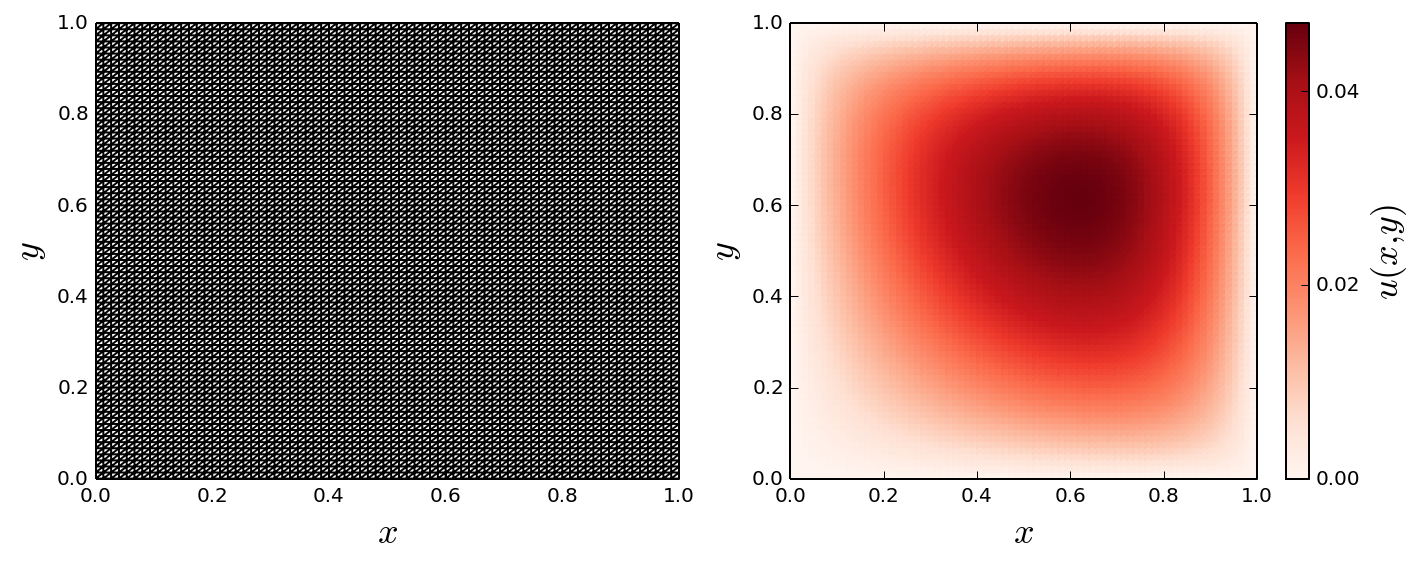

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, u_sol2.vector().array(), cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

fig.savefig("ch11-fdm-2d-ex2.pdf")
fig.savefig("ch11-fdm-2d-ex2.png")
fig.tight_layout()

## Dirichlet boundary conditions

In [79]:
N1 = N2 = 75

In [80]:
mesh = dolfin.RectangleMesh(0, 0, 1, 1, N1, N2)

In [81]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

DEBUG:FFC:Reusing form from cache.


In [82]:
u = dolfin.TrialFunction(V)

In [83]:
v = dolfin.TestFunction(V)

In [84]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [85]:
f = dolfin.Constant(0.0)

In [86]:
L = f * v * dolfin.dx

In [87]:
def u0_top_boundary(x, on_boundary):
    return on_boundary and abs(x[1]-1) < 1e-8

In [88]:
def u0_bottom_boundary(x, on_boundary):
    return on_boundary and abs(x[1]) < 1e-8

In [89]:
def u0_left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < 1e-8

In [90]:
def u0_right_boundary(x, on_boundary):
    return on_boundary and abs(x[0]-1) < 1e-8

In [91]:
bc_t = dolfin.DirichletBC(V, dolfin.Constant(5), u0_top_boundary)
bc_b = dolfin.DirichletBC(V, dolfin.Constant(-5), u0_bottom_boundary)
bc_l = dolfin.DirichletBC(V, dolfin.Constant(3), u0_left_boundary)
bc_r = dolfin.DirichletBC(V, dolfin.Constant(-1), u0_right_boundary)

In [92]:
bcs = [bc_t, bc_b, bc_r, bc_l]

In [93]:
u_sol = dolfin.Function(V)

In [94]:
dolfin.solve(a == L, u_sol, bcs)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [95]:
u_mat = u_sol.vector().array().reshape(N1+1, N2+1)

In [96]:
x = np.linspace(0, 1, N1+2)
y = np.linspace(0, 1, N1+2)
X, Y = np.meshgrid(x, y)

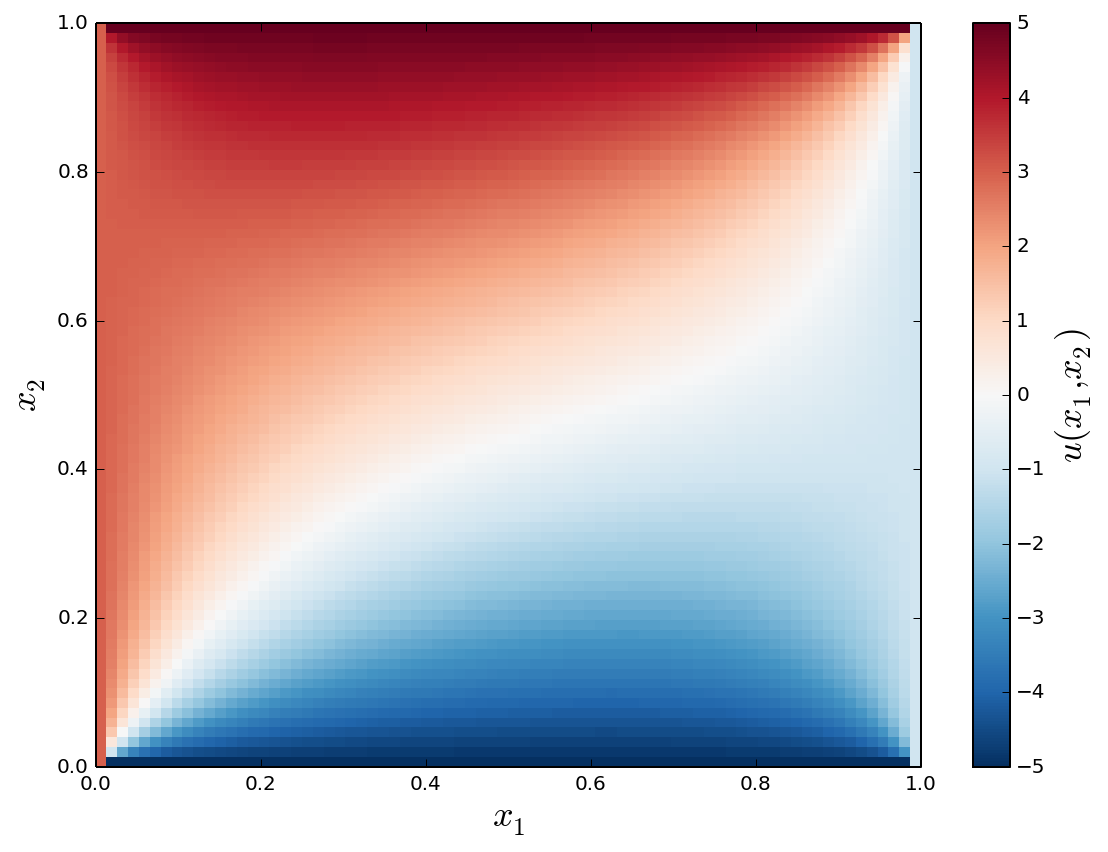

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

c = ax.pcolor(X, Y, u_mat, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
fig.savefig("ch11-fdm-2d-ex3.pdf")
fig.savefig("ch11-fdm-2d-ex3.png")
fig.tight_layout()

## Circular geometry

In [98]:
r_outer = 1
r_inner = 0.25
r_middle = 0.1
x0, y0 = 0.4, 0.4

In [99]:
domain = mshr.Circle(dolfin.Point(.0, .0), r_outer) \
    - mshr.Circle(dolfin.Point(.0, .0), r_inner) \
    - mshr.Circle(dolfin.Point( x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point( x0, -y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0, -y0), r_middle)

In [100]:
mesh = mshr.generate_mesh(domain, 10)

In [101]:
mesh

In [102]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

DEBUG:FFC:Reusing form from cache.


In [103]:
u = dolfin.TrialFunction(V)

In [104]:
v = dolfin.TestFunction(V)

In [105]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [106]:
f = dolfin.Constant(1.0)

In [107]:
L = f * v * dolfin.dx

In [108]:
def u0_outer_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_outer) < 5e-2

In [109]:
def u0_inner_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_inner) < 5e-2

In [110]:
def u0_middle_boundary(x, on_boundary):
    x, y = x[0], x[1]
    if on_boundary:
        for _x0 in [-x0, x0]:
            for _y0 in [-y0, y0]:
                if abs(np.sqrt((x+_x0)**2 + (y+_y0)**2) - r_middle) < 5e-2:
                    return True
    
    return False

In [111]:
bc_inner = dolfin.DirichletBC(V, dolfin.Constant(15), u0_inner_boundary)
bc_middle = dolfin.DirichletBC(V, dolfin.Constant(0), u0_middle_boundary)

In [112]:
bcs = [bc_inner, bc_middle]

In [113]:
u_sol = dolfin.Function(V)

In [114]:
dolfin.solve(a == L, u_sol, bcs)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [115]:
triangulation = mesh_triangulation(mesh)

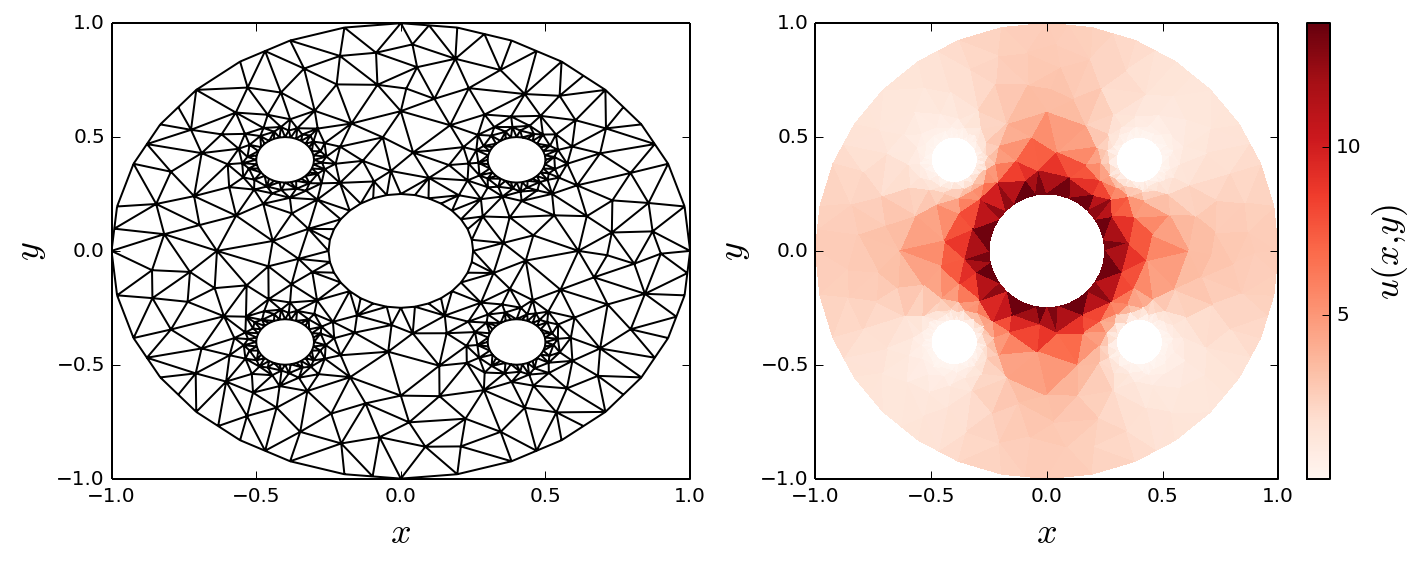

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, u_sol.vector().array(), cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 5, 10, 15])

fig.savefig("ch11-fdm-2d-ex4.pdf")
fig.savefig("ch11-fdm-2d-ex4.png")
fig.tight_layout()

### Post processing

In [117]:
outer_boundary = dolfin.AutoSubDomain(lambda x, on_bnd: on_bnd and abs(np.sqrt(x[0]**2 + x[1]**2) - r_outer) < 5e-2)

In [118]:
bc_outer = dolfin.DirichletBC(V, 1, outer_boundary)

In [119]:
mask_outer = dolfin.Function(V)

In [120]:
bc_outer.apply(mask_outer.vector())

In [121]:
u_outer = u_sol.vector()[mask_outer.vector() == 1]

In [122]:
x_outer = mesh.coordinates()[mask_outer.vector() == 1]

In [123]:
phi = np.angle(x_outer[:, 0] + 1j * x_outer[:, 1])

In [124]:
order = np.argsort(phi)

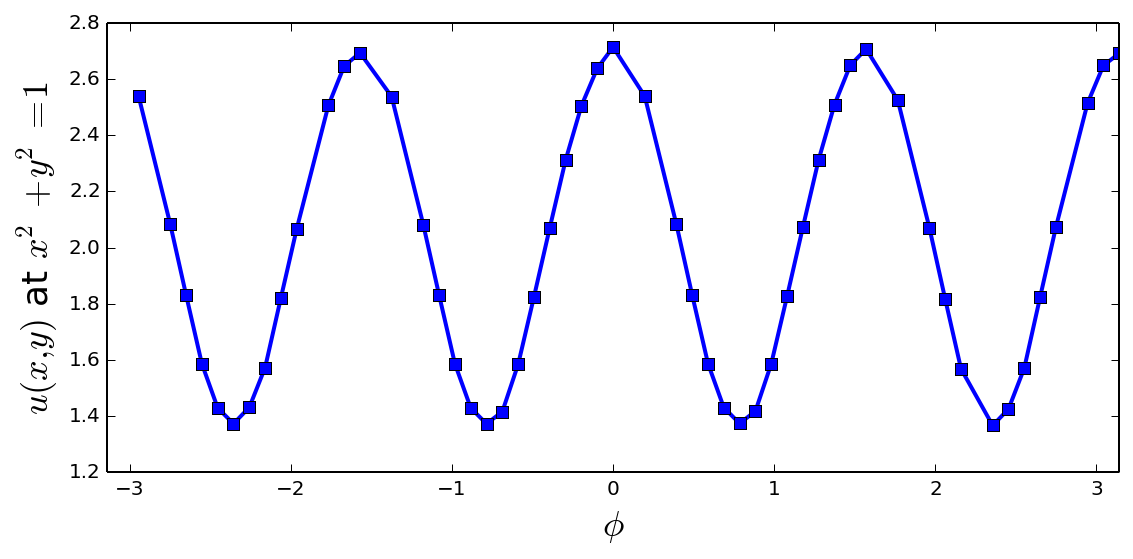

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(phi[order], u_outer[order], 's-', lw=2)
ax.set_ylabel(r"$u(x,y)$ at $x^2+y^2=1$", fontsize=18)
ax.set_xlabel(r"$\phi$", fontsize=18)
ax.set_xlim(-np.pi, np.pi)
fig.tight_layout()
fig.savefig("ch11-fem-2d-ex5.pdf")

## Mesh refining

In [126]:
domain = mshr.Circle(dolfin.Point(.0, .0), 1.0) - mshr.Rectangle(dolfin.Point(0.0, -1.0), dolfin.Point(1.0, 0.0))

In [127]:
mesh = mshr.generate_mesh(domain, 10)

In [128]:
refined_mesh = mesh
for r in [0.5, 0.25]:
    cell_markers = dolfin.CellFunction("bool", refined_mesh)
    cell_markers.set_all(False)
    for cell in dolfin.cells(refined_mesh):
        if cell.distance(dolfin.Point(.0, .0)) < r:
            cell_markers[cell] = True
    refined_mesh = dolfin.refine(refined_mesh, cell_markers)

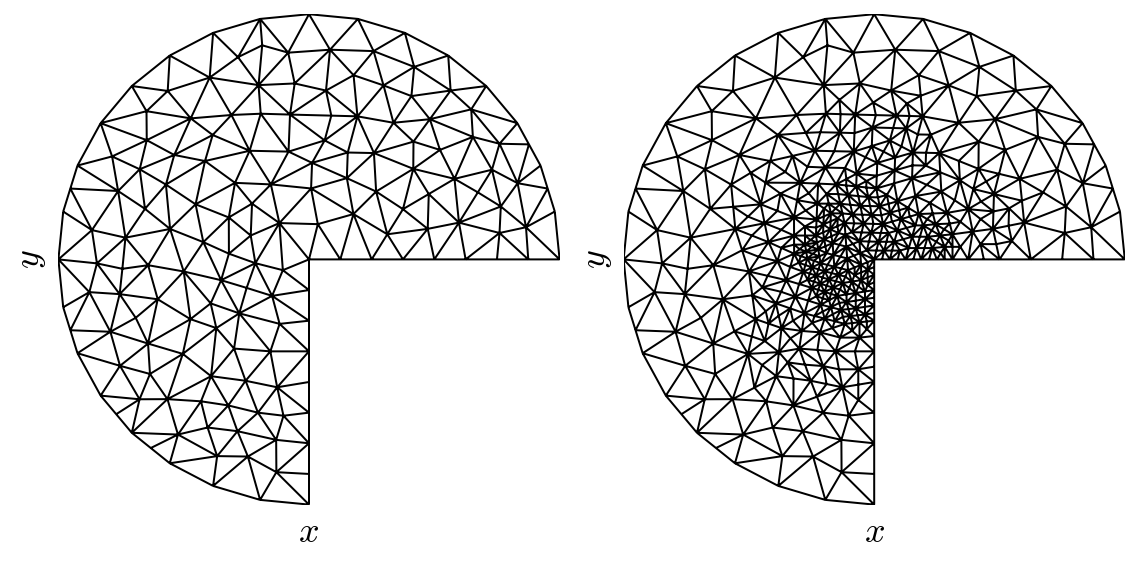

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
 
ax1.triplot(mesh_triangulation(mesh))
ax2.triplot(mesh_triangulation(refined_mesh))

for ax in [ax1, ax2]:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

    ax.set_xlabel(r"$x$", fontsize=18)
    ax.set_ylabel(r"$y$", fontsize=18)
 
fig.savefig("ch11-fem-2d-mesh-refine.pdf")
fig.savefig("ch11-fem-2d-mesh-refine.png")
fig.tight_layout()

### Refined mesh with Dirichlet boundary conditions

In [130]:
mesh = refined_mesh

In [131]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

DEBUG:FFC:Reusing form from cache.


In [132]:
u = dolfin.TrialFunction(V)

In [133]:
v = dolfin.TestFunction(V)

In [134]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [135]:
f = dolfin.Constant(0.0)

In [136]:
L = f * v * dolfin.dx

In [137]:
def u0_vertical_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(x) < 1e-2 and y < 0.0

In [138]:
def u0_horizontal_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(y) < 1e-2 and x > 0.0

In [139]:
bc_vertical = dolfin.DirichletBC(V, dolfin.Constant(-5), u0_vertical_boundary)

In [140]:
bc_horizontal = dolfin.DirichletBC(V, dolfin.Constant(5), u0_horizontal_boundary)

In [141]:
bcs = [bc_vertical, bc_horizontal]

In [142]:
u_sol = dolfin.Function(V)

In [143]:
dolfin.solve(a == L, u_sol, bcs)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [144]:
triangulation = mesh_triangulation(mesh)

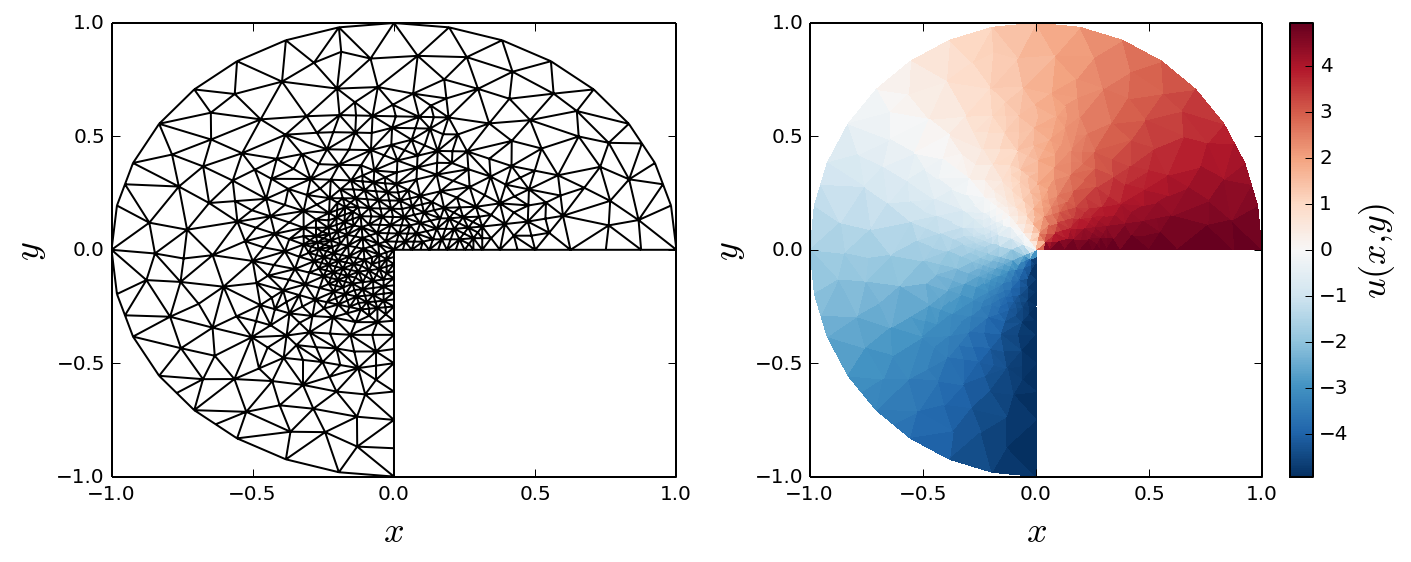

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
 
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
 
c = ax2.tripcolor(triangulation, u_sol.vector().array(), cmap=mpl.cm.get_cmap("RdBu_r"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)

fig.tight_layout()

## Refined mesh with Dirichlet and von Neumann boundary conditions

In [146]:
mesh = refined_mesh

In [147]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

DEBUG:FFC:Reusing form from cache.


In [148]:
u = dolfin.TrialFunction(V)

In [149]:
v = dolfin.TestFunction(V)

In [150]:
boundary_parts = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim()-1)

In [151]:
def v_boundary_func(x, on_boundary):
    """ the vertical edge of the mesh, where x = 0 and y < 0"""
    x, y = x[0], x[1]
    return on_boundary and abs(x) < 1e-4 and y < 0.0

In [152]:
v_boundary = dolfin.AutoSubDomain(v_boundary_func)

In [153]:
v_boundary.mark(boundary_parts, 0)

In [154]:
def h_boundary_func(x, on_boundary):
    """ the horizontal edge of the mesh, where y = 0 and x > 0"""
    x, y = x[0], x[1]
    return on_boundary and abs(y) < 1e-4 and x > 0.0

In [155]:
h_boundary = dolfin.AutoSubDomain(h_boundary_func)

In [156]:
h_boundary.mark(boundary_parts, 1)

In [157]:
def outer_boundary_func(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(x**2 + y**2-1) < 1e-2

In [158]:
outer_boundary = dolfin.AutoSubDomain(outer_boundary_func)

In [159]:
outer_boundary.mark(boundary_parts, 2)

In [160]:
bc = dolfin.DirichletBC(V, dolfin.Constant(0.0), boundary_parts, 2)

In [161]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx(domain=mesh, subdomain_data=boundary_parts)

In [162]:
f = dolfin.Constant(0.0)

In [163]:
g_v = dolfin.Constant(-2.0)

In [164]:
g_h = dolfin.Constant(1.0)

In [165]:
L = f * v * dolfin.dx(domain=mesh, subdomain_data=boundary_parts)

In [166]:
L += g_v * v * dolfin.ds(0, domain=mesh, subdomain_data=boundary_parts)

In [167]:
L += g_h * v * dolfin.ds(1, domain=mesh, subdomain_data=boundary_parts)

In [168]:
u_sol = dolfin.Function(V)

In [169]:
dolfin.solve(a == L, u_sol, bc)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [170]:
triangulation = mesh_triangulation(mesh)